<a href="https://colab.research.google.com/github/GabrielFePL/Sugestao-de-Noticia-LSTM/blob/main/Estudo04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rede Neural Recorrente para Predição de Notícias Sugeridas

## Base de Dados Histórica Simulada

### Importação das Bibliotecas

In [69]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

### Função de Geração da Base de Dados e Registros

In [70]:
def generate_simulated_data(num_users, num_access, num_subcategories, start_date):
  data = []

  # Definir preferências por subcategorias para cada usuário
  user_preferences = {user_id: random.choices(range(1, num_subcategories+1), k=num_subcategories) for user_id in range(1, num_users+1)}

  # Definir perfil de horário de cada usuário
  user_profile = {user_id: random.choice(['morning', 'afternoon', 'evening', 'night']) for user_id in range(1, num_users+1)}

  morning_hours = list(range(6, 12))
  afternoon_hours = list(range(12, 18))
  evening_hours = list(range(18, 24))
  night_hours = list(range(0, 6))

  accesses_per_user = num_access // num_users

  for i in range(1, num_users + 1):
    user_id = i

    # Ajustar horários com base no perfil do usuário
    profile = user_profile[user_id]
    if profile == 'morning':
      time_slots = morning_hours * 4 + evening_hours * 2 + afternoon_hours * 1 + night_hours * 1
    elif profile == 'afternoon':
      time_slots = afternoon_hours * 4 + evening_hours * 2 + morning_hours * 1 + night_hours * 1
    elif profile == 'evening':
      time_slots = evening_hours * 4 + morning_hours * 2 + afternoon_hours * 1 + night_hours * 1
    else:
      time_slots = night_hours * 4 + evening_hours * 2 + afternoon_hours * 1 + morning_hours * 1

    current_timestamp = start_date

    for r in range(accesses_per_user):
      # Probabilidade maior de acessar subcategorias favoritas
      subcategory_id = random.choices(user_preferences[user_id], weights=[0.4 if sc == user_preferences[user_id][0] else 0.3 for sc in user_preferences[user_id]], k=1)[0]

      # Simulação de horários com mais acessos
      hour_bias = random.choices(time_slots, k=1)[0]
      current_timestamp = current_timestamp.replace(hour=hour_bias, minute=random.randint(0, 59))

      month = current_timestamp.month
      day = current_timestamp.day
      hour = current_timestamp.hour
      minute = current_timestamp.minute
      day_of_week = current_timestamp.weekday()

      data.append([user_id, subcategory_id, current_timestamp, month, day, hour, minute, day_of_week])

      current_timestamp += timedelta(days=random.randint(1, 3), hours=random.randint(0, 5))

  columns = ['User_ID', 'Subcategory_ID', 'Current_Timestamp', 'Time_Component_Month', 'Time_Component_Day', 'Time_Component_Hour', 'Time_Component_Minute', 'Time_Component_Day_of_Week']
  df = pd.DataFrame(data, columns=columns)

  return df

### Geração da Base de Dados

In [71]:
# Definição da Simulação
num_users = 500
num_accesses = 100000
num_subcategories = 15
start_date = datetime(2024, 3, 1)

# Chamada da Função de Geração
simulated_data = generate_simulated_data(num_users, num_accesses, num_subcategories, start_date)

### Visualização da Base de Dados

In [72]:
simulated_data

,User_ID,Subcategory_ID,Current_Timestamp,Time_Component_Month,Time_Component_Day,Time_Component_Hour,Time_Component_Minute,Time_Component_Day_of_Week
0,1,12,2024-03-01 21:08:00,3,1,21,8,4
1,1,12,2024-03-05 16:51:00,3,5,16,51,1
2,1,11,2024-03-07 03:34:00,3,7,3,34,3
3,1,1,2024-03-08 13:32:00,3,8,13,32,4
4,1,11,2024-03-10 01:18:00,3,10,1,18,6
...,...,...,...,...,...,...,...,...
99995,500,11,2025-04-25 22:44:00,4,25,22,44,4
99996,500,11,2025-04-28 19:14:00,4,28,19,14,0
99997,500,12,2025-04-29 16:31:00,4,29,16,31,1
99998,500,11,2025-04-30 12:17:00,4,30,12,17,2


In [73]:
simulated_data.describe()

,User_ID,Subcategory_ID,Current_Timestamp,Time_Component_Month,Time_Component_Day,Time_Component_Hour,Time_Component_Minute,Time_Component_Day_of_Week
count,100000.000,100000.000000,100000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,250.500,8.000900,2024-09-29 20:58:11.227200,6.109460,15.504930,12.318330,29.472920,3.006610
min,1.000,1.000000,2024-03-01 00:01:00,1.000000,1.000000,0.000000,0.000000,0.000000
25%,125.750,4.000000,2024-06-14 20:35:30,3.000000,8.000000,6.000000,14.000000,1.000000
50%,250.500,8.000000,2024-09-29 10:38:00,6.000000,15.000000,12.000000,29.000000,3.000000
75%,375.250,12.000000,2025-01-14 05:26:15,9.000000,23.000000,19.000000,44.000000,5.000000
max,500.000,15.000000,2025-06-19 18:58:00,12.000000,31.000000,23.000000,59.000000,6.000000
std,144.338,4.357493,NaN,3.358263,8.819427,7.031863,17.327114,1.999542


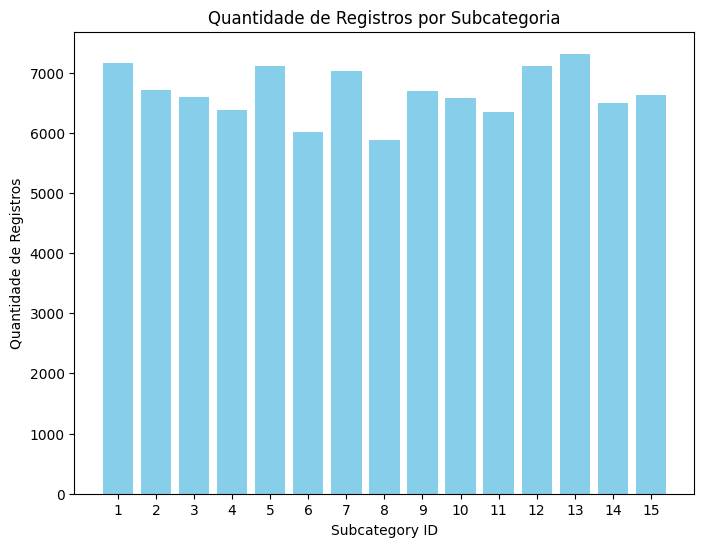

In [74]:
subcategory_counts = simulated_data['Subcategory_ID'].value_counts()

plt.figure(figsize = (8, 6))
plt.bar(subcategory_counts.index, subcategory_counts.values, color = 'skyblue')
plt.xlabel('Subcategory ID')
plt.ylabel('Quantidade de Registros')
plt.title('Quantidade de Registros por Subcategoria')
plt.xticks(subcategory_counts.index)
plt.show()

### Visualização de Usuário Aleatório

In [75]:
random_user1 = random.randint(1, num_users)
simulated_data[simulated_data['User_ID'] == random_user1]

,User_ID,Subcategory_ID,Current_Timestamp,Time_Component_Month,Time_Component_Day,Time_Component_Hour,Time_Component_Minute,Time_Component_Day_of_Week
73400,368,7,2024-03-01 11:44:00,3,1,11,44,4
73401,368,4,2024-03-02 10:59:00,3,2,10,59,5
73402,368,8,2024-03-03 08:25:00,3,3,8,25,6
73403,368,4,2024-03-06 08:13:00,3,6,8,13,2
73404,368,13,2024-03-08 15:57:00,3,8,15,57,4
...,...,...,...,...,...,...,...,...
73595,368,1,2025-05-07 22:02:00,5,7,22,2,2
73596,368,4,2025-05-11 10:35:00,5,11,10,35,6
73597,368,14,2025-05-13 22:02:00,5,13,22,2,1
73598,368,4,2025-05-17 07:11:00,5,17,7,11,5


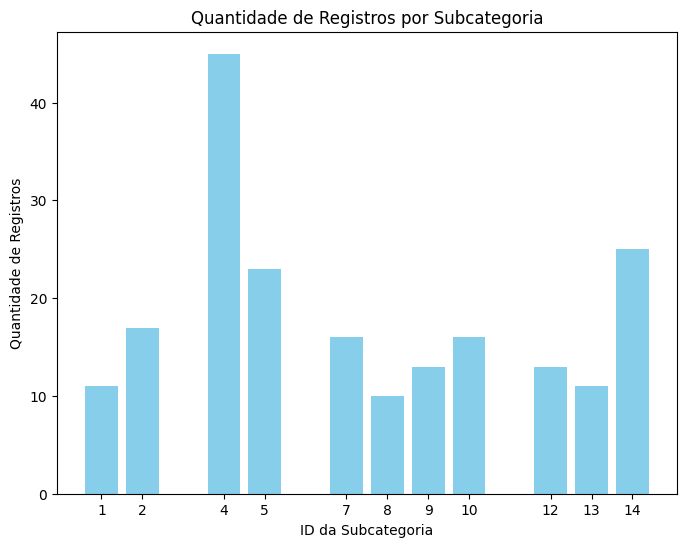

In [76]:
subcategory_counts = simulated_data[simulated_data['User_ID'] == random_user1]['Subcategory_ID'].value_counts()

plt.figure(figsize = (8, 6))
plt.bar(subcategory_counts.index, subcategory_counts.values, color = 'skyblue')
plt.xlabel('ID da Subcategoria')
plt.ylabel('Quantidade de Registros')
plt.title('Quantidade de Registros por Subcategoria')
plt.xticks(subcategory_counts.index)
plt.show()

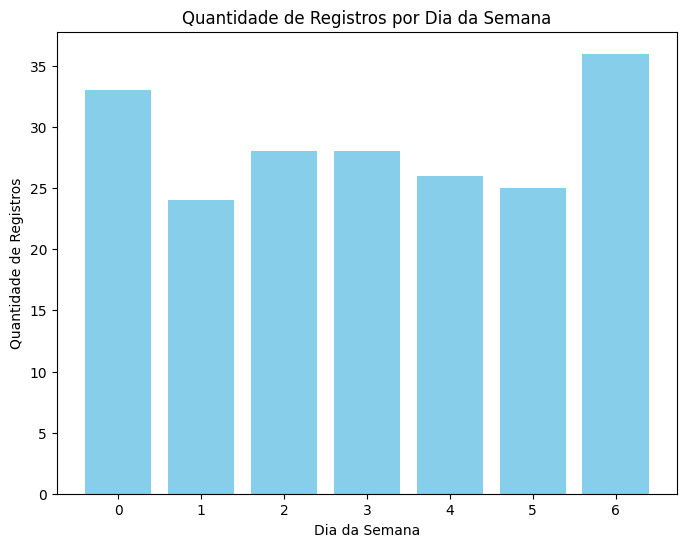

In [77]:
day_counts = simulated_data[simulated_data['User_ID'] == random_user1]['Time_Component_Day_of_Week'].value_counts()

plt.figure(figsize = (8, 6))
plt.bar(day_counts.index, day_counts.values, color = 'skyblue')
plt.xlabel('Dia da Semana')
plt.ylabel('Quantidade de Registros')
plt.title('Quantidade de Registros por Dia da Semana')
plt.xticks(day_counts.index)
plt.show()

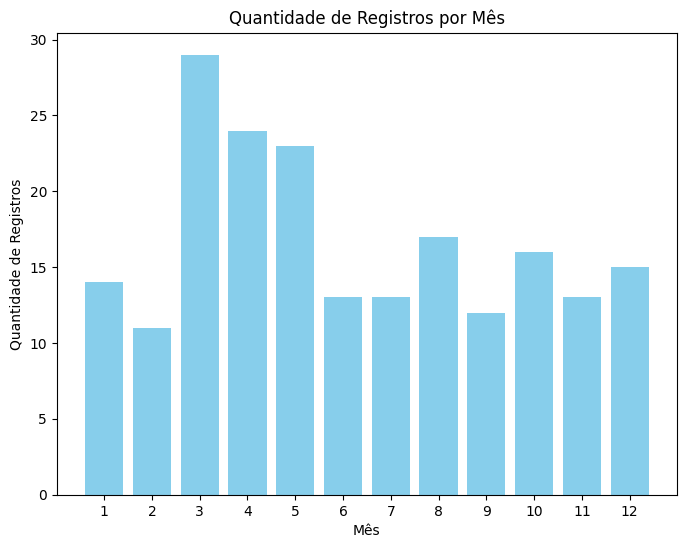

In [78]:
month_counts = simulated_data[simulated_data['User_ID'] == random_user1]['Time_Component_Month'].value_counts()

plt.figure(figsize = (8, 6))
plt.bar(month_counts.index, month_counts.values, color = 'skyblue')
plt.xlabel('Mês')
plt.ylabel('Quantidade de Registros')
plt.title('Quantidade de Registros por Mês')
plt.xticks(month_counts.index)
plt.show()

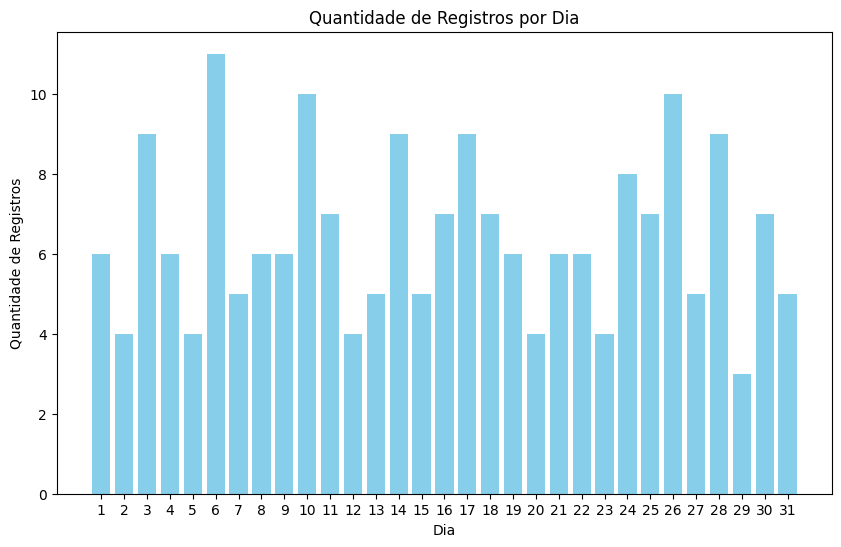

In [79]:
day_counts = simulated_data[simulated_data['User_ID'] == random_user1]['Time_Component_Day'].value_counts()

plt.figure(figsize = (10, 6))
plt.bar(day_counts.index, day_counts.values, color = 'skyblue')
plt.xlabel('Dia')
plt.ylabel('Quantidade de Registros')
plt.title('Quantidade de Registros por Dia')
plt.xticks(day_counts.index)
plt.show()

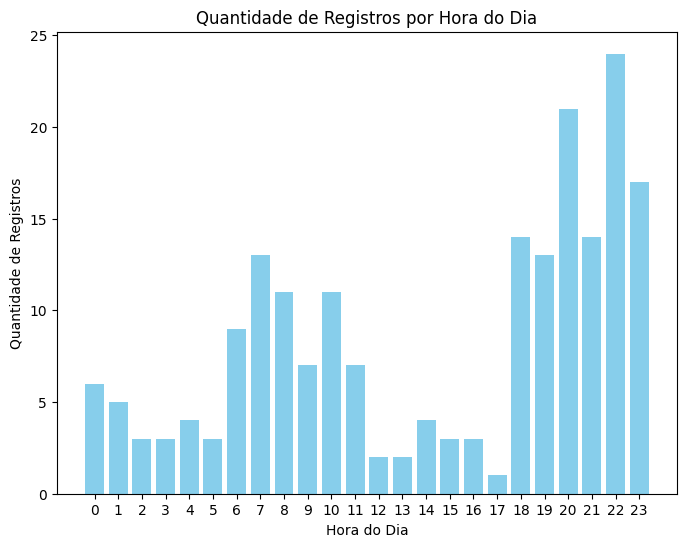

In [80]:
hour_counts = simulated_data[simulated_data['User_ID'] == random_user1]['Time_Component_Hour'].value_counts()

plt.figure(figsize = (8, 6))
plt.bar(hour_counts.index, hour_counts.values, color = 'skyblue')
plt.xlabel('Hora do Dia')
plt.ylabel('Quantidade de Registros')
plt.title('Quantidade de Registros por Hora do Dia')
plt.xticks(hour_counts.index)
plt.show()

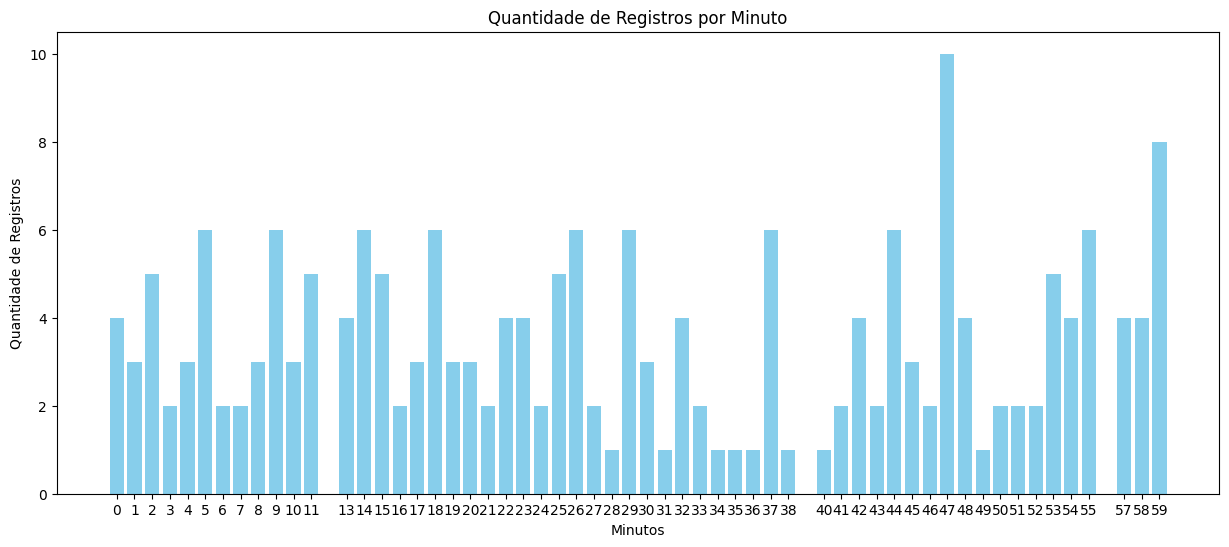

In [81]:
minute_counts = simulated_data[simulated_data['User_ID'] == random_user1]['Time_Component_Minute'].value_counts()

plt.figure(figsize = (15, 6))
plt.bar(minute_counts.index, minute_counts.values, color = 'skyblue')
plt.xlabel('Minutos')
plt.ylabel('Quantidade de Registros')
plt.title('Quantidade de Registros por Minuto')
plt.xticks(minute_counts.index)
plt.show()

### Exportação da Base de Dados

In [82]:
simulated_data.to_csv('simulated_data.csv', index = False)

## Tratamento dos Dados para Ingestão do Modelo

### Importação das Bibliotecas

In [83]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [84]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importação da Base de Dados

In [85]:
db = pd.read_csv('/content/simulated_data.csv')
db

,User_ID,Subcategory_ID,Current_Timestamp,Time_Component_Month,Time_Component_Day,Time_Component_Hour,Time_Component_Minute,Time_Component_Day_of_Week
0,1,12,2024-03-01 21:08:00,3,1,21,8,4
1,1,12,2024-03-05 16:51:00,3,5,16,51,1
2,1,11,2024-03-07 03:34:00,3,7,3,34,3
3,1,1,2024-03-08 13:32:00,3,8,13,32,4
4,1,11,2024-03-10 01:18:00,3,10,1,18,6
...,...,...,...,...,...,...,...,...
99995,500,11,2025-04-25 22:44:00,4,25,22,44,4
99996,500,11,2025-04-28 19:14:00,4,28,19,14,0
99997,500,12,2025-04-29 16:31:00,4,29,16,31,1
99998,500,11,2025-04-30 12:17:00,4,30,12,17,2


### Tratamento de Valores Irrelevantes

In [86]:
db = db.drop('Current_Timestamp', axis = 1)
db.head(1)

,User_ID,Subcategory_ID,Time_Component_Month,Time_Component_Day,Time_Component_Hour,Time_Component_Minute,Time_Component_Day_of_Week
0,1,12,3,1,21,8,4


### Normalização dos Dados

In [87]:
scaler = MinMaxScaler()
db[['Subcategory_ID', 'Time_Component_Month', 'Time_Component_Day', 'Time_Component_Hour', 'Time_Component_Minute', 'Time_Component_Day_of_Week']] = scaler.fit_transform(db[['Subcategory_ID', 'Time_Component_Month', 'Time_Component_Day', 'Time_Component_Hour', 'Time_Component_Minute', 'Time_Component_Day_of_Week']])
db.head(10)

,User_ID,Subcategory_ID,Time_Component_Month,Time_Component_Day,Time_Component_Hour,Time_Component_Minute,Time_Component_Day_of_Week
0,1,0.785714,0.181818,0.000000,0.913043,0.135593,0.666667
1,1,0.785714,0.181818,0.133333,0.695652,0.864407,0.166667
2,1,0.714286,0.181818,0.200000,0.130435,0.576271,0.500000
3,1,0.000000,0.181818,0.233333,0.565217,0.542373,0.666667
4,1,0.714286,0.181818,0.300000,0.043478,0.305085,1.000000
5,1,0.500000,0.181818,0.333333,1.000000,0.576271,0.000000
6,1,0.785714,0.181818,0.466667,0.478261,0.135593,0.666667
7,1,0.785714,0.181818,0.566667,0.869565,0.186441,0.000000
8,1,0.428571,0.181818,0.700000,0.565217,0.254237,0.666667
9,1,0.000000,0.181818,0.733333,0.608696,0.101695,0.833333


### Criação de Sequências Temporais

In [88]:
def create_sequences(data, n_steps):
  X, y = [], []
  for i in range(len(data) - n_steps):
    X.append(data[i : i + n_steps])
    y.append(data[i + n_steps])
  return np.array(X), np.array(y)

X_all, y_all = [], []

for user_id in db['User_ID'].unique():
  user_data = db[db['User_ID'] == user_id].drop('User_ID', axis = 1).values
  n_steps = 5
  X, y = create_sequences(user_data, n_steps)

  X_all.append(X)
  y_all.append(y)

X_all = np.concatenate(X_all, axis = 0)
y_all = np.concatenate(y_all, axis = 0)
print(X_all.shape)
print(y_all.shape)

(97500, 5, 6)
(97500, 6)


### Redimensionamento dos Dados

In [89]:
X_all = X_all.reshape((X_all.shape[0], X_all.shape[1], X_all.shape[2]))
print(X_all.shape)

y_all = y_all[:, 0]
y_all = y_all.reshape(-1, 1)
print(y_all.shape)

(97500, 5, 6)
(97500, 1)


### Divisão dos Dados entre Treinamento e Teste

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size = 0.2, random_state = 42, shuffle = False)

print(f"Tamanho do conjunto de treinamento (X_train): {X_train.shape}")
print(f"Tamanho do conjunto de teste (X_test): {X_test.shape}")
print(f"Tamanho do conjunto de treinamento (y_train): {y_train.shape}")
print(f"Tamanho do conjunto de teste (y_test): {y_test.shape}")

Tamanho do conjunto de treinamento (X_train): (78000, 5, 6)
Tamanho do conjunto de teste (X_test): (19500, 5, 6)
Tamanho do conjunto de treinamento (y_train): (78000, 1)
Tamanho do conjunto de teste (y_test): (19500, 1)


In [91]:
db.head(6)

,User_ID,Subcategory_ID,Time_Component_Month,Time_Component_Day,Time_Component_Hour,Time_Component_Minute,Time_Component_Day_of_Week
0,1,0.785714,0.181818,0.000000,0.913043,0.135593,0.666667
1,1,0.785714,0.181818,0.133333,0.695652,0.864407,0.166667
2,1,0.714286,0.181818,0.200000,0.130435,0.576271,0.500000
3,1,0.000000,0.181818,0.233333,0.565217,0.542373,0.666667
4,1,0.714286,0.181818,0.300000,0.043478,0.305085,1.000000
5,1,0.500000,0.181818,0.333333,1.000000,0.576271,0.000000


In [92]:
X_train[0]

array([[0.78571429, 0.18181818, 0.        , 0.91304348, 0.13559322,
        0.66666667],
       [0.78571429, 0.18181818, 0.13333333, 0.69565217, 0.86440678,
        0.16666667],
       [0.71428571, 0.18181818, 0.2       , 0.13043478, 0.57627119,
        0.5       ],
       [0.        , 0.18181818, 0.23333333, 0.56521739, 0.54237288,
        0.66666667],
       [0.71428571, 0.18181818, 0.3       , 0.04347826, 0.30508475,
        1.        ]])

In [93]:
y_train[0]

array([0.5])

In [94]:
np.save('X_train_LSTM.npy', X_train)
np.save('X_test_LSTM.npy', X_test)
np.save('y_train_LSTM.npy', y_train)
np.save('y_test_LSTM.npy', y_test)

## Modelo LSTM

### Importação das Bibliotecas

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

### Importação dos Dados de Treinamento e Teste

In [96]:
X_train_LSTM = np.load('/content/X_train_LSTM.npy')
X_test_LSTM = np.load('/content/X_test_LSTM.npy')
y_train_LSTM = np.load('/content/y_train_LSTM.npy')
y_test_LSTM = np.load('/content/y_test_LSTM.npy')

print(f"Tamanho do conjunto de treinamento (X_train_LSTM): {X_train_LSTM.shape}")
print(f"Tamanho do conjunto de teste (X_test_LSTM): {X_test_LSTM.shape}")
print(f"Tamanho do conjunto de treinamento (y_train_LSTM): {y_train_LSTM.shape}")
print(f"Tamanho do conjunto de teste (y_test_LSTM): {y_test_LSTM.shape}")

Tamanho do conjunto de treinamento (X_train_LSTM): (78000, 5, 6)
Tamanho do conjunto de teste (X_test_LSTM): (19500, 5, 6)
Tamanho do conjunto de treinamento (y_train_LSTM): (78000, 1)
Tamanho do conjunto de teste (y_test_LSTM): (19500, 1)


### Criação do Modelo LSTM

In [97]:
# Definição do Modelo
model = Sequential()

# Definição da Primeira Camada
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train_LSTM.shape[1], X_train_LSTM.shape[2])))

# Definição da Segunda Camada
model.add(LSTM(units = 50))

# Definição da Camada de Saída
model.add(Dense(units = 1))

# Compilador e Otimizador do Modelo
model.compile(optimizer = Adam(learning_rate = 0.001), loss = 'mse', metrics = ['mae'])

# Resumo do Modelo
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 5, 50)               │          11,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,651 (123.64 KB)

 Trainable params: 31,651 (123.64 KB)

 Non-trainable params: 0 (0.00 B)

### Treinamento do Modelo

In [105]:
history = model.fit(X_train_LSTM, y_train_LSTM, epochs = 8, batch_size = 8, validation_data = (X_test_LSTM, y_test_LSTM))

Epoch 1/8
8945/9750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0943 - mae: 0.2659

KeyboardInterrupt: 

### Avaliação do Modelo

In [100]:
y_pred = model.predict(X_test_LSTM)

610/610 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [101]:
mae = mean_absolute_error(y_test_LSTM, y_pred)
mae

0.2727256759418236

In [102]:
rmse = np.sqrt(mean_squared_error(y_test_LSTM, y_pred))
rmse

0.3141563995246671

In [103]:
r2 = r2_score(y_test_LSTM, y_pred)
r2

0.00941374369858583

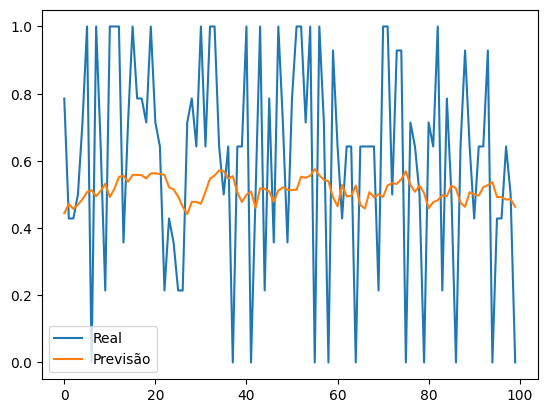

In [104]:
plt.plot(y_test[:100], label='Real')
plt.plot(y_pred[:100], label='Previsão')
plt.legend()
plt.show()

# Descrição dos Estudos

## Resumo do Estudo 01

Ao iniciar as pesquisas sobre o treinamento e a implementação de uma rede neural recorrente (RNN) para rastrear e prever os acessos de usuários às subcategorias de um portal de notícias, descobriu-se que o modelo LSTM é adequado para lidar com dados sequenciais e capturar dependências temporais em longas sequências de dados.
O Estudo 01 teve como intuito estabelecer uma base de dados fictícia adequada para o treinamento do modelo LSTM. Contudo, a base de dados gerada se mostrou ineficaz ao modelo, já que não representa os eventos temporais tão significativamente como deveria.

## Resumo do Estudo 02

Dada a ineficácia da base de dados simulada criada no Estudo 01, o objetivo do Estudo 02 foi gerar uma base de dados eficaz e balanceada para o treinamento do modelo LSTM. Neste Estudo, criou-se uma função para gerar registros aleatórios, porém, com variações probabilísticas em intervalos que representam o padrão de comportamento do usuário. Além de sessões dedicadas à visualização da base de dados e usuários para confirmação de sua eficácia. Mais adiante no Estudo 02, é iniciado o Tratamento da mesma base para a etapa posterior de Ingestão de Dados do modelo.

## Resumo do Estudo 03

Após o resultado satisfatório do Estudo 02, o Estudo 03 seguiu com o Tratamento dos dados para o Treinamento do modelo LSTM. Neste Estudo, no decorrer do tratamento foram identificados pontos de melhoria na geração da base de dados, como a separação da coluna de registro temporal em componentes temporais. Além disso, foram executados processos cruciais para a preparação do modelo, como a remoção de colunas irrelevantes para o processo de aprendizagem de máquina, a normalização dos dados para garantir que sua escala semelhante facilite o processo de aprendizagem e evite um modelo enviesado, a criação de sequências que representam basicamente a ordem cronológica dos registros para o modelo, o redimensionamento dos dados para garantir que os dados de entrada tenham as características necessárias para o treinamento de uma LSTM (samples, time_steps, features) e a coluna de saída esteja definida (Subcategory_ID), por fim, o início da divisão entre treinamento e teste, processo este que não foi concluído neste Estudo por dificuldades encontradas na manutenção da cronologia dos registros individuais dos usuários.

## Resumo do Estudo 04